# Load numbers from images

In [1]:
from PIL import Image
import os
import ast 
import numpy as np
import random
from file_util import (getImagePath,imageToBiPolar,saveOutput,randomFlip,hardLimit,compare_image,compare_state)

maxRow = 10
maxCol = 10

# Obtain exemplars from manually generatated image files.
# Parameters: Folder, list of exemplers to train eg: [3,5]
def exemplarFromImageFiles(folderpath, listNum):
    numberImages = []
    exemplarNumbers = listNum
    for number in exemplarNumbers:
        imageName = f"{number}_bw.png"
        imagePath = getImagePath(folderpath, imageName)
        imageBW = Image.open(imagePath)
        imageArray = np.array(imageBW)
        imageArray = imageArray.astype(int)
        numberImages.append(imageArray.copy())
    return numberImages

# Read exemplars from text file with exemplars matrices.
def exemplarFromMatrix(folder_path):
    exemplars = []
    for i in range(8):
        filename = f"{i}.txt"
        file_path = os.path.join(folder_path,filename)
        with open(file_path, "r") as f:
            data = ast.literal_eval(f.read())
            exemplars.append(np.array(data))
    return np.array(exemplars)


# Two options to read exemplars:
#OPTION 1:
#   bipolarArrays that was produced from Minh's images.

#exemplarNumbers = [3,5]

exemplarNumbers = [i for i in range(0,8)]
imageFolder = f"Images{os.path.sep}BlackWhite/v0"
numberImages = exemplarFromImageFiles(imageFolder, exemplarNumbers)
bipolarArrays = [np.vectorize(imageToBiPolar)(array) for array in numberImages]

#OPTION 2:
#   bipolarArrays that was produced using Sootatt's drawing pad.

# exemplarNumbers = [i for i in range(0,8)]
# rawdataFolder = f"{os.getcwd()}{os.path.sep}input{os.path.sep}new1"
# bipolarArrays = exemplarFromMatrix(rawdataFolder)



#Debug values
for i,bipolarImage in enumerate(bipolarArrays):
    #print(f"Number {i}")
    if bipolarImage.shape != (maxRow,maxCol):
        print(f"Image does not have the correct dimension. Expect: {(maxRow,maxCol)}. Image: {(bipolarImage.shape)}")
        exit(1)
    #print(bipolarImage)

# Display training numbers

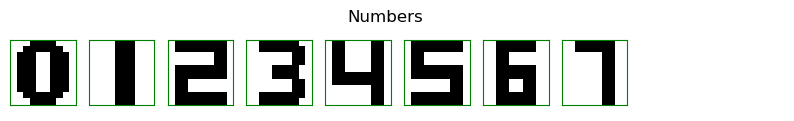

In [2]:
%matplotlib inline
import matplotlib; matplotlib.rc('axes',edgecolor='green')
import matplotlib.pyplot as plt

def plot(items, title):
    fig, axs = plt.subplots(1, 10)
    
    fig.set_size_inches(10, 1)
    
    if len(items) < 10:
        items = items + [None] * (10 - len(items))

    for ax, item in zip(axs,items):
        if item is None:
            ax.axis('off')
            continue
        img = item if len(item.shape) > 1 else np.reshape(item, (10,10))
        ax.imshow(img, cmap='Greys', interpolation='nearest')
        ax.tick_params(axis='both',which='both',grid_color='green',bottom=False,left=False,labelbottom=False,labelleft=False,labelright=False)
    
    plt.suptitle(title, y=1.12)
    fig.savefig(f"notebook/{title}", bbox_inches='tight')
    plt.show()
    plt.close(fig)
    
plot(bipolarArrays, 'Numbers')

# Training

In [3]:
# Training
'''
TODO:
1. Initialize weight with the 8 exemplars
2. Produce noisy input by randomly flip the bit of an exemplar with the probability of 0.25
3. Train the Hopfield Network
'''

# TODO: 1. Initialize weight with the 8 exemplars
weight = np.zeros((maxRow*maxRow, maxCol*maxCol))
for i,imageArray in enumerate(bipolarArrays):
    weight += np.outer(imageArray,imageArray)

#print("weight:\n", weight)
#Zero out the weight:
for i in range(len(weight)):
    weight[i][i] = 0
#print("zero weight:\n", weight)
#verify that the left diagonal is all zero
if not np.all(np.diag(weight) == 0):
    print("Error: Left diagonal values are not all zero")
    exit(1)

In [4]:
def recallNumber(exemplars, noisyInput, w, expect_examplar,threshold=0.9):
    global maxRow, maxCol
    max_iteration = 200
    statecp = np.copy(noisyInput)
    states = []
    # Asynchronous update:
    reshape_examplar = np.reshape(expect_examplar,(10,10))
    final_similar_score = 0.0
    for j in range(max_iteration):
        state =np.copy(statecp)
        # Randomize the order on which neuron to update first.
        update_order = np.random.permutation(maxRow * maxCol)
        states = [statecp]
        for i in update_order:
            # if i % 50 == 0:
            #   print("iteration:", j, "; Updating neuron:",i)
            activation = np.dot(w[i],state) + state[i]
            if activation > 0:
                state[i] = 1
            else:
                state[i] = -1

            if not (state == states[-1]).all():
                states.append(np.copy(state))
            # Check for convergence:            
            #return state
            #similar_score = compare_image(reshape_examplar,np.reshape(state,(10,10)))
            similar_score = compare_state(expect_examplar,state)
            if similar_score >= threshold:
                #print(f"Converge at iteration: {j} - update: {i}")
                #print(f"Converge at iteration: {j} - update: {i} - similar score: {similar_score:.4f}")
                return state, states, similar_score

    #print(f"similar_score is smaller than threshold: {similar_score} < {threshold}")
    return state, states, similar_score

# Experiments: Recall with noise

--------------------- target: 0


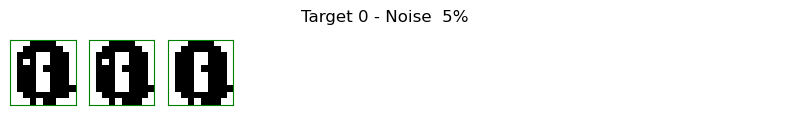

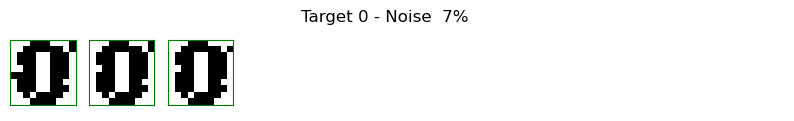

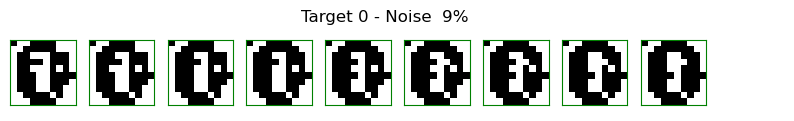

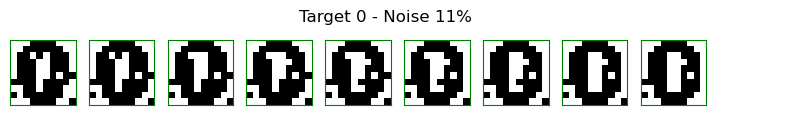

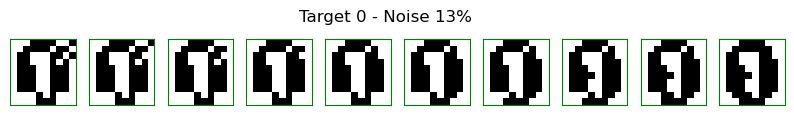

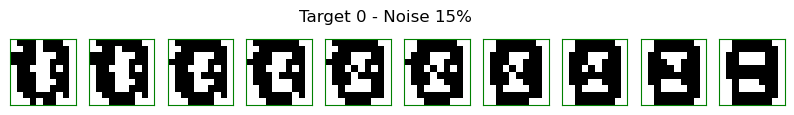

--------------------- target: 1


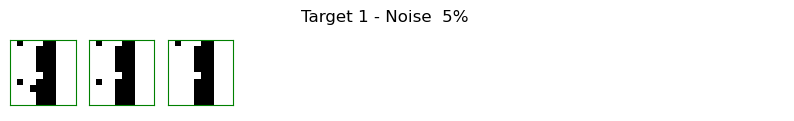

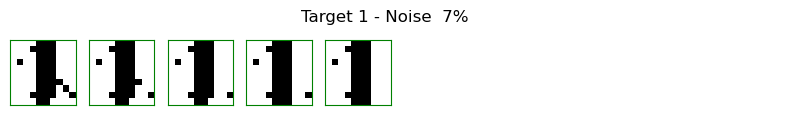

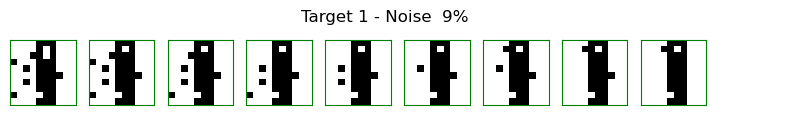

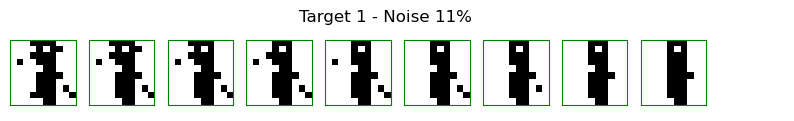

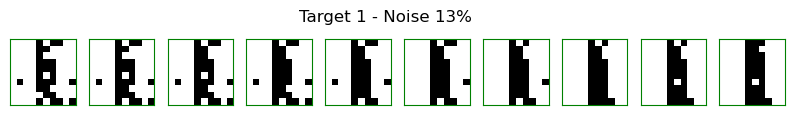

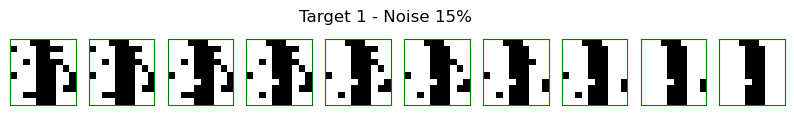

--------------------- target: 2


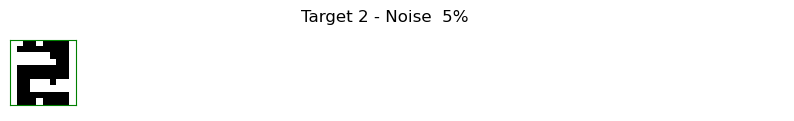

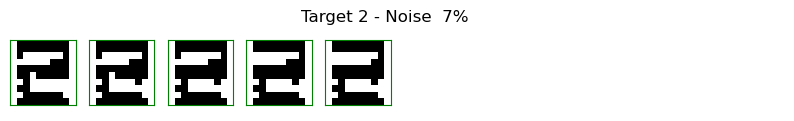

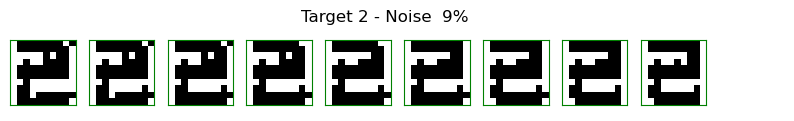

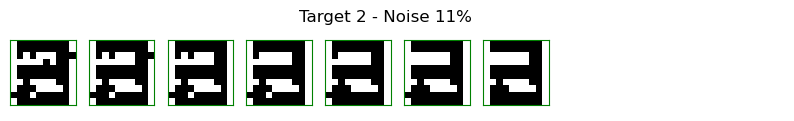

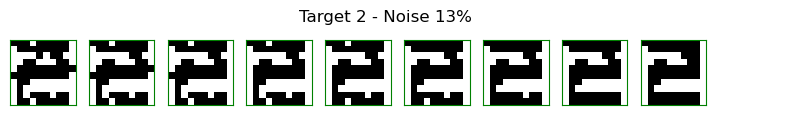

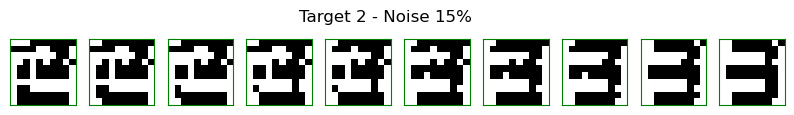

--------------------- target: 3


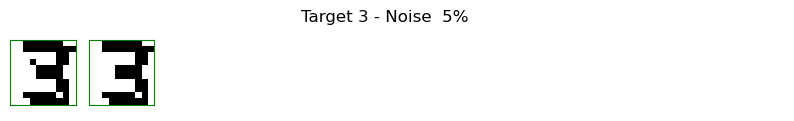

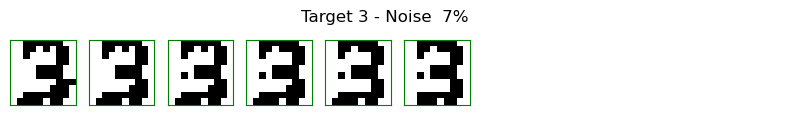

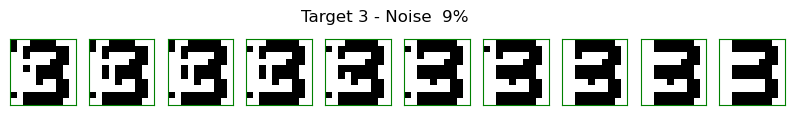

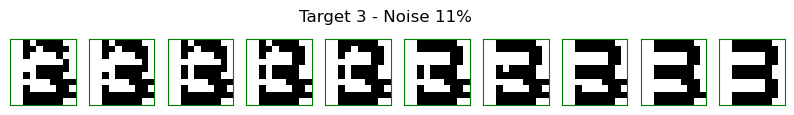

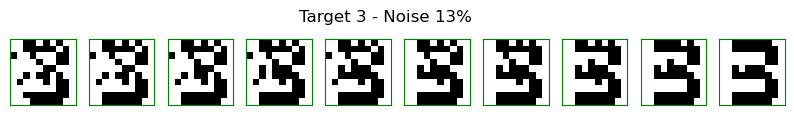

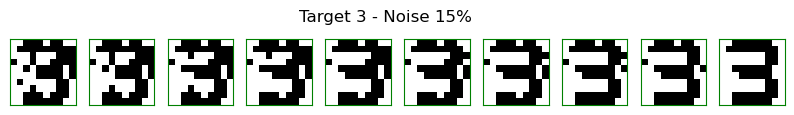

--------------------- target: 4


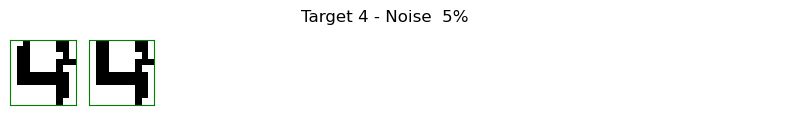

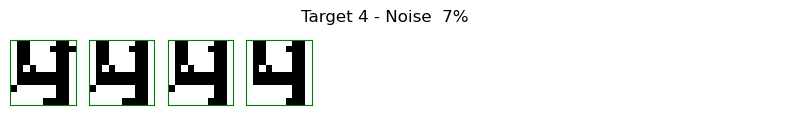

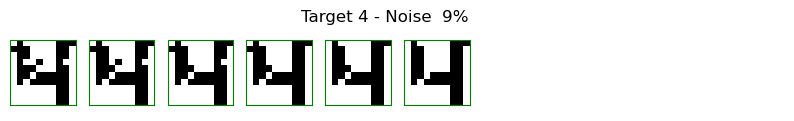

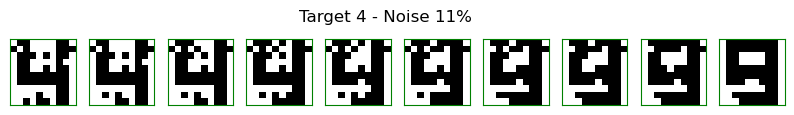

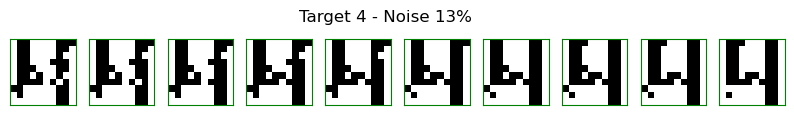

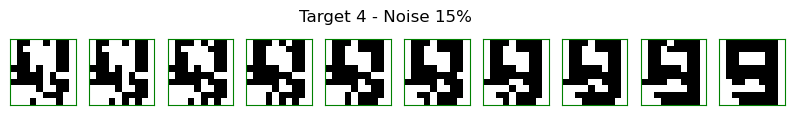

--------------------- target: 5


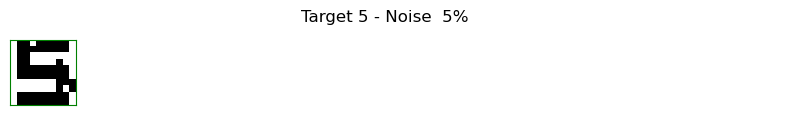

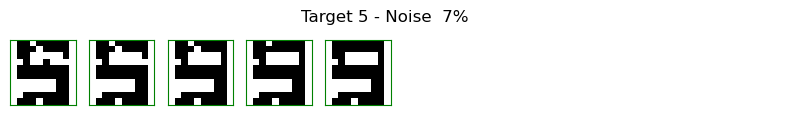

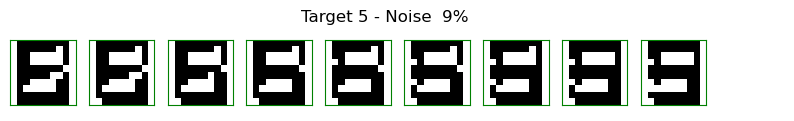

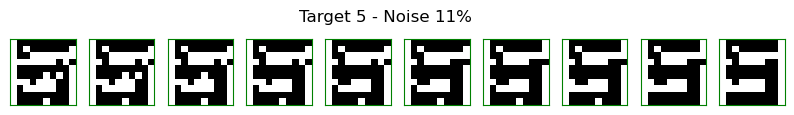

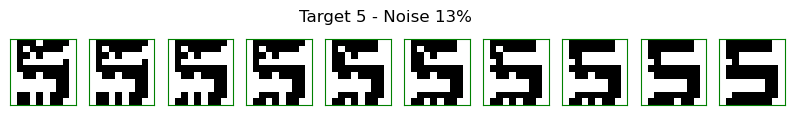

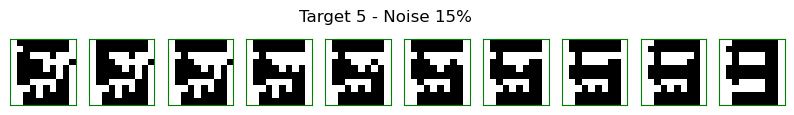

--------------------- target: 6


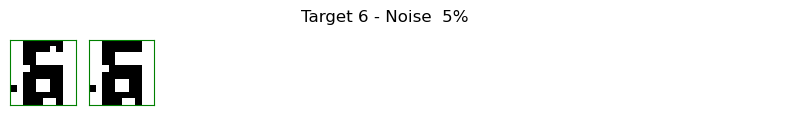

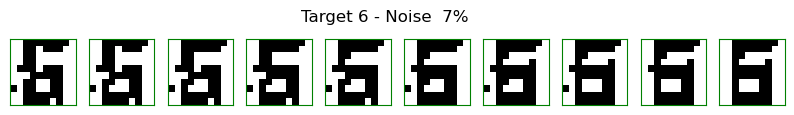

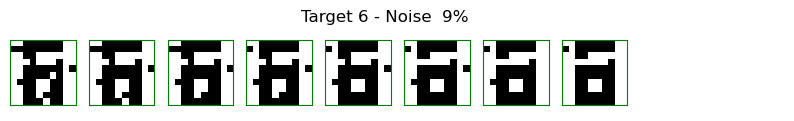

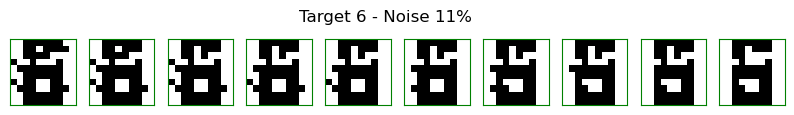

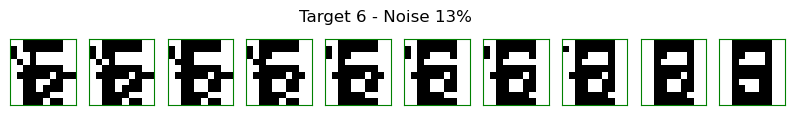

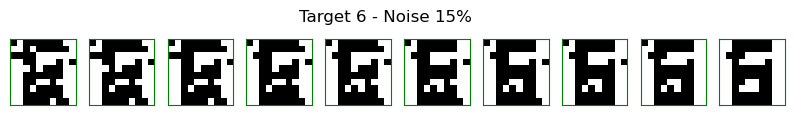

--------------------- target: 7


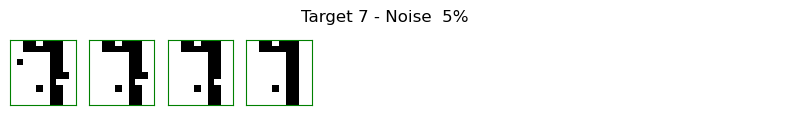

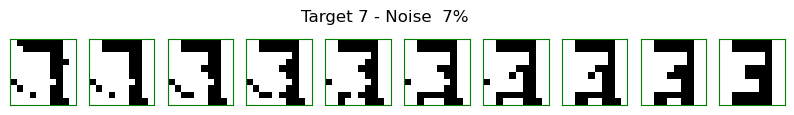

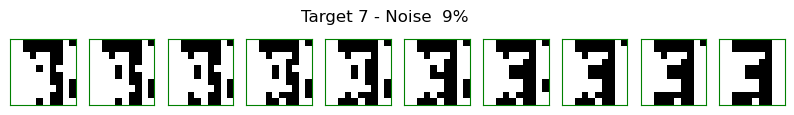

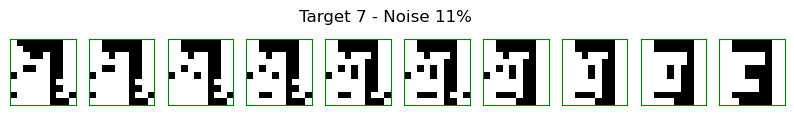

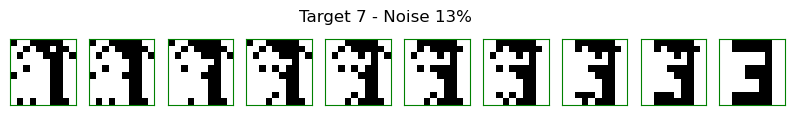

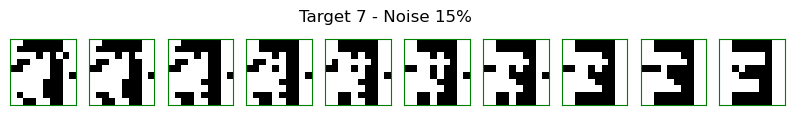

In [5]:
# --------------------------------------------------------------------------------------------------------------
flattened_bipolarArrays = []
for array in bipolarArrays:
    flattened_bipolarArrays.append(array.flatten())

#Creating noisy input of number 'target':
table = []
for target in range(8):
    print(f"--------------------- target: {target}")
    for noise_level in range(5,16,2):
        random.seed((target + 1) * noise_level)
        #noise_level = random.randint(5,5)
        chosen_img = flattened_bipolarArrays[target]
        noisyInput = np.copy(chosen_img)
        # Randomly select 5-15 indices to flip:

        flip_index = random.sample(range(0, 100), noise_level)
        for i in flip_index:
            noisyInput[i] = noisyInput[i] * -1
        #print(f"\n--------------------- target: {target}\nnoise_level: {noise_level}%")

        result, states, sim = recallNumber(flattened_bipolarArrays,noisyInput,weight,chosen_img)
        table.append((target, noise_level, sim))
        
        incr = 1 if len(states) <= 10 else len(states) / 10.0
        plot_states = [states[int(i)] for i in np.arange(0,len(states)-incr, incr)] + [states[-1]]
        plot(plot_states,f"Target {target} - Noise {noise_level:2n}%")

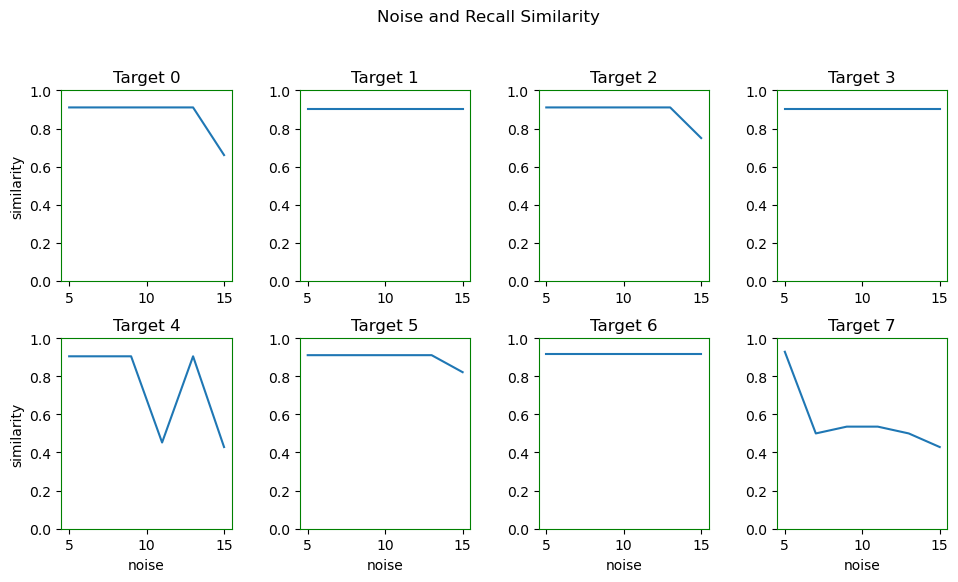

In [34]:
fig, axs = plt.subplots(2, 4)
fig.tight_layout()
fig.set_size_inches(10, 5)
plt.subplots_adjust(hspace=0.3,wspace=0.4)

for target in range(8):
    start = target * 6
    end = start + 6
    x = [e[1] for e in table[start:end]]
    y = [e[2] for e in table[start:end]]
    
    ax = axs[target // 4][target % 4]
    
    ax.set_title(f"Target {target}")
    ax.set_ylim([0.0, 1.0])
    if target >= 4:
        ax.set_xlabel('noise')
    if target == 0 or target == 4:
        ax.set_ylabel('similarity')
    ax.plot(x,y)
    
plt.suptitle('Noise and Recall Similarity', y=1.12)
fig.savefig(f"notebook/noise-similary.png", bbox_inches='tight')
plt.show()
plt.close(fig)

In [6]:
import pandas as pd
df = pd.DataFrame(table, columns=['target', 'noise', 'similarity'])
df

,target,noise,similarity
0,0,5,0.910714
1,0,7,0.910714
2,0,9,0.910714
3,0,11,0.910714
4,0,13,0.910714
5,0,15,0.660714
6,1,5,0.900000
7,1,7,0.900000
8,1,9,0.900000
9,1,11,0.900000
